# FocusGAN ECE 285 Final Project

## imports

In [8]:
import zipfile
import requests
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

notebook_path = os.getcwd()
print("Notebook path:", notebook_path)

Notebook path: /home/salsulai/private/ECE 285/Final Project


### Zip Extraction

In [16]:
#file paths
test_path = '/home/salsulai/private/ECE 285/Final Project/testSet.zip'  
train_path = '/home/salsulai/private/ECE 285/Final Project/trainSet.zip'
extract_dir = '/home/salsulai/private/ECE 285/Final Project'  

# Extraction
with zipfile.ZipFile(test_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
with zipfile.ZipFile(train_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print("Dataset Extraction Successful")

Dataset Extraction Successful


## Visualize CAT2000 Training Dataset

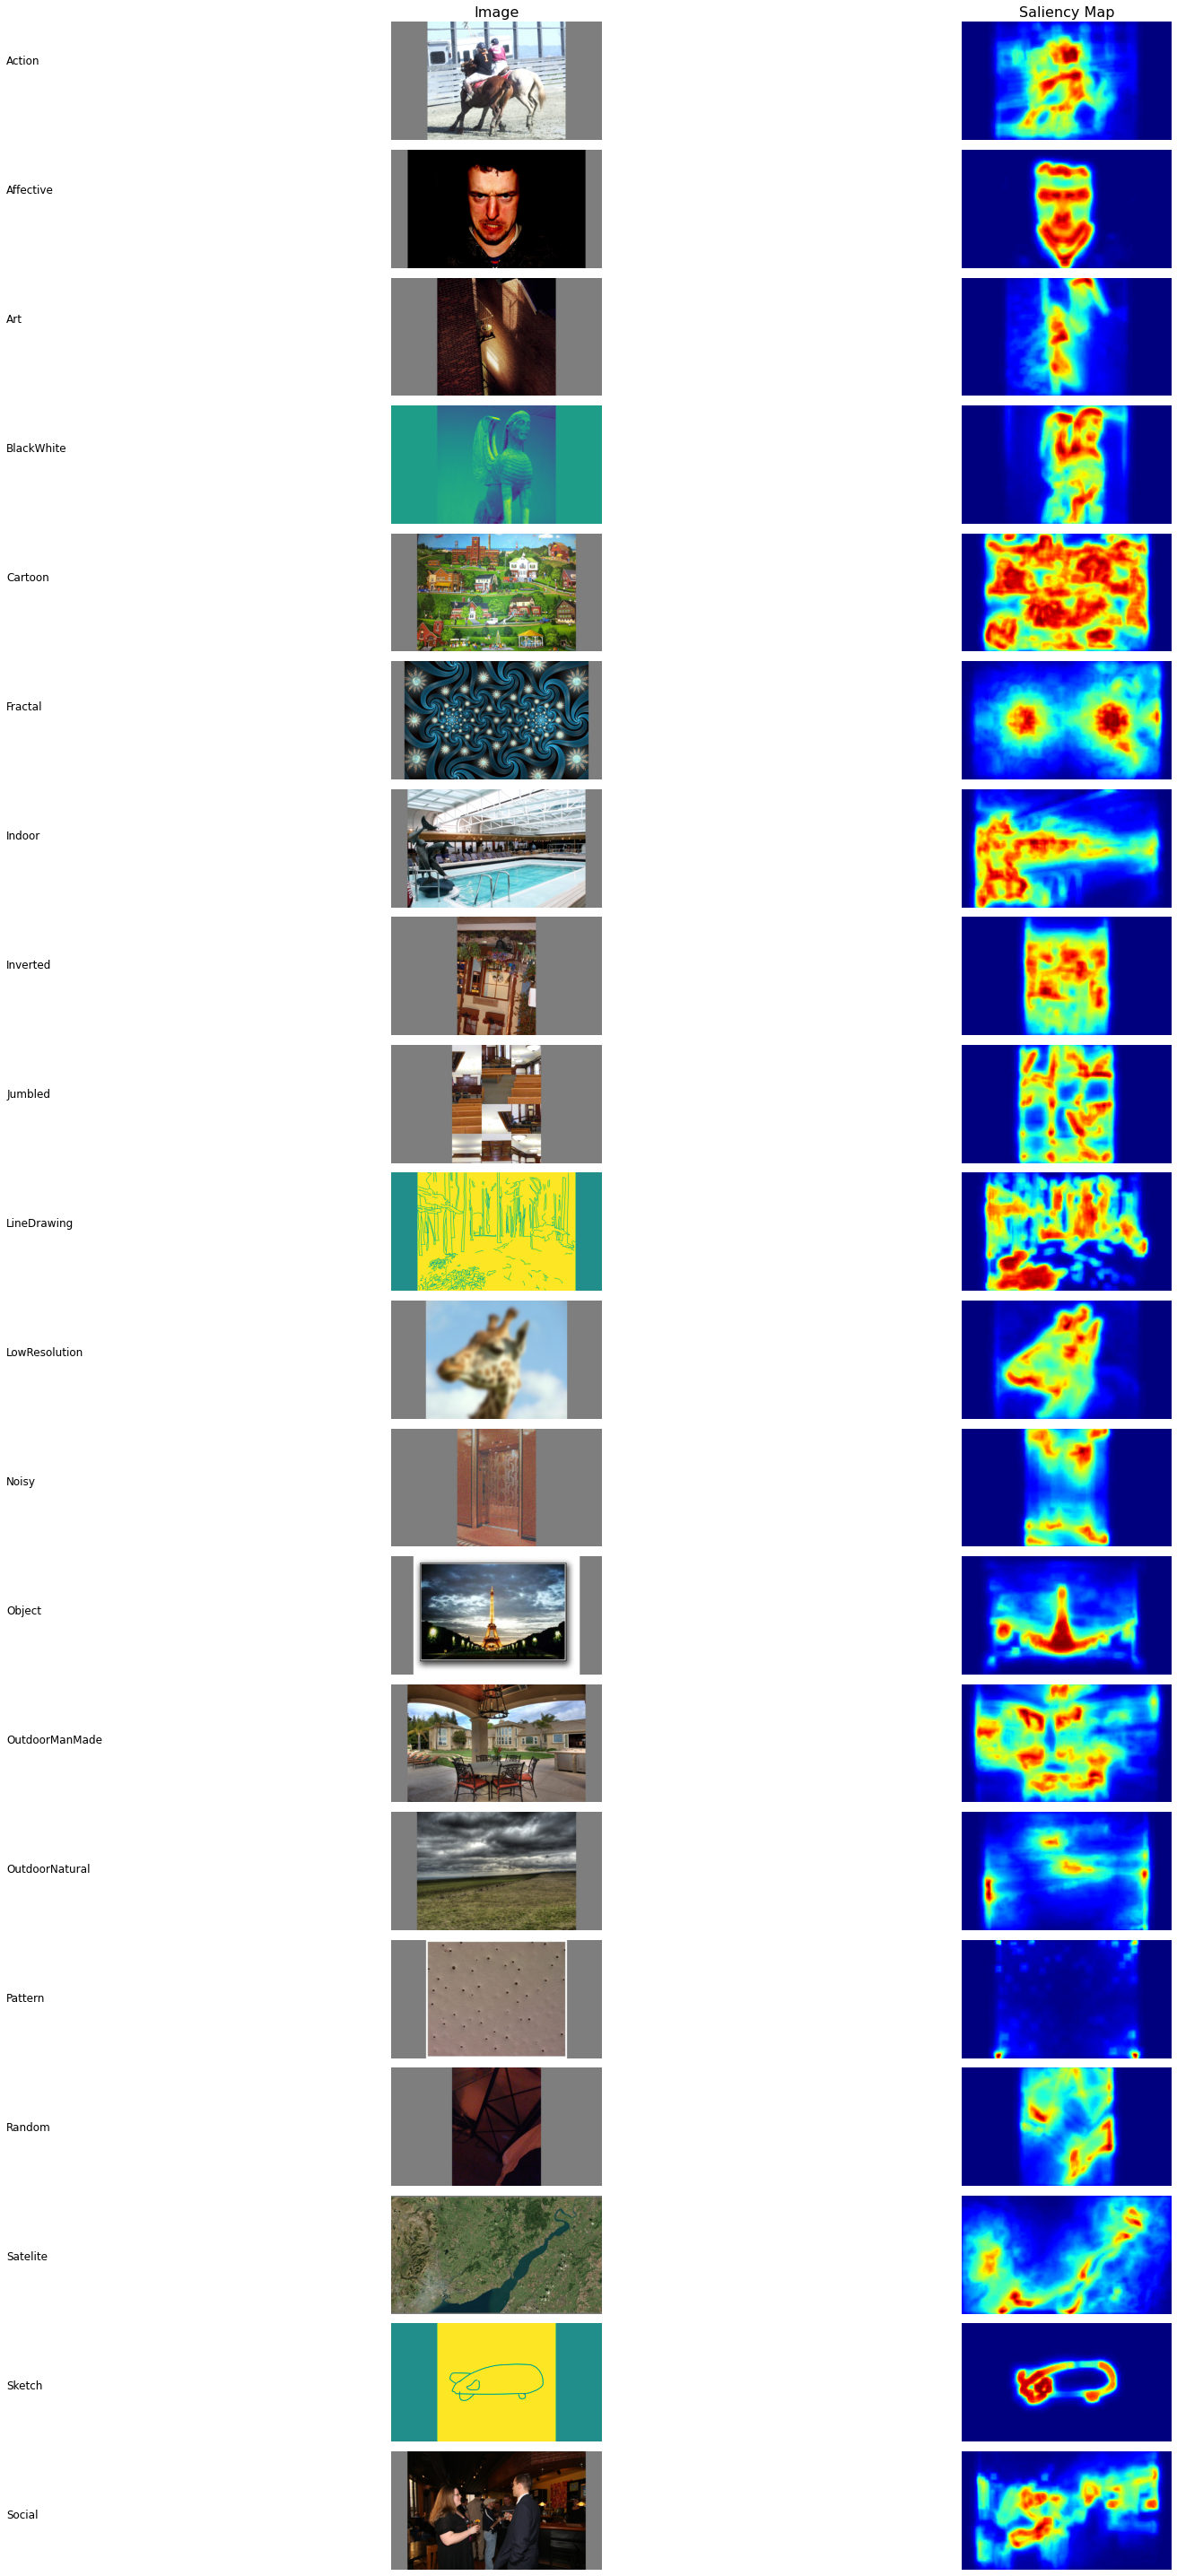

In [5]:
extract_dir = '/home/salsulai/private/ECE 285/Final Project'
Categories = ["Action","Affective","Art","BlackWhite","Cartoon","Fractal","Indoor","Inverted","Jumbled","LineDrawing",
"LowResolution","Noisy","Object","OutdoorManMade","OutdoorNatural","Pattern","Random","Satelite","Sketch","Social"]



file_list = os.listdir(extract_dir + "/trainSet/Stimuli/Action")
random_image = random.choice(file_list)

rows = 20
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(24, 40))
x = 0
for i in Categories:
    file_list_stim = os.listdir(extract_dir + "/trainSet/Stimuli/" + i)
    random_image = random.choice(file_list_stim)
    image_path = os.path.join(extract_dir + "/trainSet/Stimuli/" + i, random_image)
    saliency_map = random_image.replace(".jpg","")+ "_SaliencyMap.jpg"
    saliency_map_path = os.path.join(extract_dir + "/trainSet/Stimuli/" + i + "/Output/", saliency_map ) 
    image = plt.imread(image_path)
    saliency_map = plt.imread(saliency_map_path)
    
    #display random image from trainset category
    axes[x, 0].imshow(image)
    axes[x, 0].axis('off')
    
    #display its respective saliency map
    axes[x, 1].imshow(saliency_map, cmap='jet')  # Adjust cmap as needed
    axes[x, 1].axis('off')
    
    #Column title 
    if x == 0:
        axes[x, 0].set_title('Image', fontsize=16)
        axes[x, 1].set_title('Saliency Map', fontsize=16)

    # Row labels
    fig.text(0, (rows-x-0.5)/rows, i, ha='left', va='center', fontsize=12)
    
    x += 1
    
    
plt.tight_layout()
plt.show()
    


## Dataloader and Device Setup

In [9]:

#Function to create data_list which is list of tuples (image_path,ground_truth_path) 
def get_data_list(root_directory):
    data_list = []
    for category in Categories:
        category_dir = os.path.join(root_directory,category)
        ground_truth_dir = os.path.join(category_dir,"Output")
        
        for image in os.listdir(category_dir):
            if image.endswith("jpg"):
                image_path = os.path.join(category_dir,image)
                ground_truth_path = os.path.join(ground_truth_dir,image.replace(".jpg","")+ "_SaliencyMap.jpg")
            
                data_list.append((image_path,ground_truth_path))
        
    return data_list

#data_list from training data
train_dir = '/home/salsulai/private/ECE 285/Final Project/trainSet/Stimuli/'
data_list = get_data_list(train_dir)

#split data_list into training and validation datasets
train_data,val_data = train_test_split(data_list, test_size = 0.2, random_state = 28) #random seed same for debugging purposes

#test set 
test_dir = '/home/salsulai/private/ECE 285/Final Project/testSet/Stimuli/'
test_data = get_data_list(test_dir)


#2000 test, 2000 training, and 400 validation seems unreasonable 
#get full data list 
full_data_list = data_list + test_data 

#split into 80, 20, 20
train_data, temp = train_test_split(full_data_list, test_size = 0.2, random_state = 28) #random seed same for debugging purposes
test_data, val_data = train_test_split(temp, test_size = 0.5, random_state = 28) #random seed same for debugging purposes



print("Training Set Size:", len(train_data))
print("Validation Set Size:", len(val_data))
print("Test Set Size:", len(test_data))

train_loader = torch.utils.data.DataLoader(     #might need to change batch_size depending on training
    train_data, batch_size=1, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=1, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=1, shuffle=False
)



USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)
    
    

Training Set Size: 3200
Validation Set Size: 400
Test Set Size: 400
using device: cuda


## Generator

## U-Net Generator 

In [ ]:


class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        #Defining U-Net Generator Layers
        self.conv1_1 = nn.Conv2d(3, 64, 1, stride = 1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, 3, stride = 1, padding=1)
        self.pool1 =  nn.MaxPool2d(2, stride=2, padding = 0, ceil_mode = True) #ceil mode
        self.conv2_1 = nn.Conv2d(64, 128, 3, stride = 1, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, 3, stride = 1, padding=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, padding = 0, ceil_mode = True)
        self.conv3_1 = nn.Conv2d(128, 256, 3, stride = 1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, 3, stride = 1, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, 3, stride = 1, padding=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, padding = 0, ceil_mode = True)
        self.conv4_1 = nn.Conv2d(256, 512, 3, stride = 1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.pool4 = nn.MaxPool2d(2, stride=2, padding = 0, ceil_mode = True)
        self.conv5_1 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv6_1 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv6_2 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv6_3 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.upsample6 = nn.ConvTranspose2d(512, 512, 2, stride = 2, bias = False) #i think bias should be false
        self.conv7_1 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv7_2 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.conv7_3 = nn.Conv2d(512, 512, 3, stride = 1, padding=1)
        self.upsample7 = nn.ConvTranspose2d(512, 512, 2, stride = 2, bias = False)
        self.conv8_1 = nn.Conv2d(512, 256, 3, stride = 1, padding=1)
        self.conv8_2 = nn.Conv2d(256, 256, 3, stride = 1, padding=1)
        self.conv8_1 = nn.Conv2d(256, 256, 3, stride = 1, padding=1)
        self.upsample8 = nn.ConvTranspose2d(256, 256, 2, stride = 2, bias = False)
        self.conv9_1 = nn.Conv2d(256, 128, 3, stride = 1, padding=1)
        self.conv9_2 = nn.Conv2d(128, 128, 3, stride = 1, padding=1)
        self.upsample9 = nn.ConvTranspose2d(128, 128, 2, stride = 2, bias = False)
        self.conv10_1 = nn.Conv2d(128, 64, 3, stride = 1, padding=1)
        self.conv10_2 = nn.Conv2d(64, 64, 3, stride = 1, padding=1)
        self.output = nn.Conv2d(64, 1, 1, stride = 1, padding=0)
        #activation layers
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

        
        #initialize encoder layer weights using VGG16 pretrained weights
        self.copy_params_from_vgg16(vgg16)
        #initialize decoder layer weights randomly using Xavier Initialization
        self._initialize_weights()

        
    def _initialize_weights(self):
        #only randomly initialize weights of decoder layers we use Xavier Initialization
        decoder_layers = [self.conv6_1, self.conv6_2, self.conv6_3, self.upsample6,
                         self.conv7_1, self.conv7_2, self.conv7_3, self.upsample7,
                         self.conv8_1, self.conv8_2, self.conv8_3, self.upsample8,
                         self.conv9_1, self.conv9_2, self.upsample9,
                         self.conv10_1, self.conv10_2, self.output]
        for layer in decoder_layers:
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                layer.bias.data.zero_()


    def forward(self, x):
        
        x = self.relu(self.conv1_1(x))
        x = self.relu(self.conv1_2(x))
        #Save Layer 1 Output
        conv1_fmap = x 
        x = self.pool1(x)
        
        x = self.relu(self.conv2_1(x))
        x = self.relu(self.conv2_2(x))
        #Save Layer 2 Output
        conv2_fmap = x      
        x = self.pool2(x)
        
        x = self.relu(self.conv3_1(x))
        x = self.relu(self.conv3_2(x))
        x = self.relu(self.conv3_3(x))
        #Save Layer 3 Output
        conv3_fmap = x      
        x = self.pool3(x)
        
        x = self.relu(self.conv4_1(x))
        x = self.relu(self.conv4_2(x))
        x = self.relu(self.conv4_3(x))
        #Save Layer 4 Output
        conv4_fmap = x    
        x = self.pool4(x)
        
        x = self.relu(self.conv5_1(x))
        x = self.relu(self.conv5_2(x))
        x = self.relu(self.conv5_3(x))
        
        x = self.relu(self.conv6_1(x))
        x = self.relu(self.conv6_2(x))
        x = self.relu(self.conv6_3(x))
        x = self.upsample6(x)
        
        #Conactenate upsampled fmap with conv4_fmap
        x = torch.cat([conv4_fmap,x])
        x = self.relu(self.conv7_1(x))
        x = self.relu(self.conv7_2(x))
        x = self.relu(self.conv7_3(x))
        x = self.upsample7(x)
        
        #Conactenate upsampled fmap with conv3_fmap
        x = torch.cat([conv3_fmap,x])
        x = self.relu(self.conv8_1(x))
        x = self.relu(self.conv8_2(x))
        x = self.relu(self.conv8_3(x))
        x = self.upsample8(x)
        
        #Conactenate upsampled fmap with conv2_fmap
        x = torch.cat([conv2_fmap,x])
        x = self.relu(self.conv9_1(x))
        x = self.relu(self.conv9_2(x))
        x = self.upsample9(x)
        
        #Conactenate upsampled fmap with conv1_fmap
        x = torch.cat([conv1_fmap,x])
        x = self.relu(self.conv10_1(x))
        x = self.relu(self.conv10_2(x))
        x = self.sigmoid(self.output(x))  

        return x

    
    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1,
            self.conv1_2,
            self.pool1,
            self.conv2_1,
            self.conv2_2,
            self.pool2,
            self.conv3_1,
            self.conv3_2,
            self.conv3_3,
            self.pool3,
            self.conv4_1,
            self.conv4_2,
            self.conv4_3,
            self.pool4,
            self.conv5_1,
            self.conv5_2,
            self.conv5_3,
        ]
        
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data = l1.weight.data.view(l2.weight.size())
            l2.bias.data = l1.bias.data.view(l2.bias.size())
        
        #fix layer weights before last two convolutional layers of VGG16
        fixed_weight_layers = [self.conv1_1, self.conv1_2,
            self.conv2_1, self.conv2_2,
            self.conv3_1, self.conv3_2, self.conv3_3]
        for layer in fixed_weight_layers:
            for param in layer.parameters():
                param.requires_grad = False
            



## Training U-Net Generator

## Discriminator 

In [11]:


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #Defining Discriminator Layers
        self.conv1_1 = nn.Conv2d(4, 3, 1, stride = 1, padding=1)
        self.conv1_2 = nn.Conv2d(3, 32, 3, stride = 1, padding=1)
        self.pool1 =  nn.MaxPool2d(2, stride=2, padding = 0, ceil_mode = True)
        self.conv2_1 = nn.Conv2d(32, 64, 3, stride = 1, padding=1)
        self.conv2_2 = nn.Conv2d(64, 64, 3, stride = 1, padding=1)
        self.pool2 =  nn.MaxPool2d(2, stride=2, padding = 0, ceil_mode = True)
        self.conv3_1 = nn.Conv2d(64, 64, 3, stride = 1, padding=1)
        self.conv3_2 = nn.Conv2d(64, 64, 3, stride = 1, padding=1)
        self.pool3 =  nn.MaxPool2d(2, stride=2, padding = 0, ceil_mode = True)
        self.fc4 = nn.Linear(64,100)
        self.fc5 = nn.Linear(100,2)
        self.fc6 = nn.Linear(2,1)

        #activation layers
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

        
        #initialize decoder layer weights randomly using Xavier Initialization
        self._initialize_discriminator_weights()

        
    def _initialize_discriminator_weights(self):
        #only randomly initialize weights of decoder layers we use Xavier Initialization
        for layer in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    layer.bias.data.zero_()



    def forward(self, x):
        
        x = self.relu(self.conv1_1(x))
        x = self.relu(self.conv1_2(x))
        x = self.pool1(x)
        
        x = self.relu(self.conv2_1(x))
        x = self.relu(self.conv2_2(x))     
        x = self.pool2(x)
        
        x = self.relu(self.conv3_1(x))
        x = self.relu(self.conv3_2(x))  
        x = self.pool3(x)
        
        x = self.tanh(self.fc4(x))
        
        x = self.tanh(self.fc5(x))
        
        x = self.sigmoid(self.fc6(x))

        return x


## Loss Functions and Optimizers

## Trainer

## Results